
Accidents by Weather:
 weather
Clear    10
Rain      6
Fog       4
Name: count, dtype: int64 



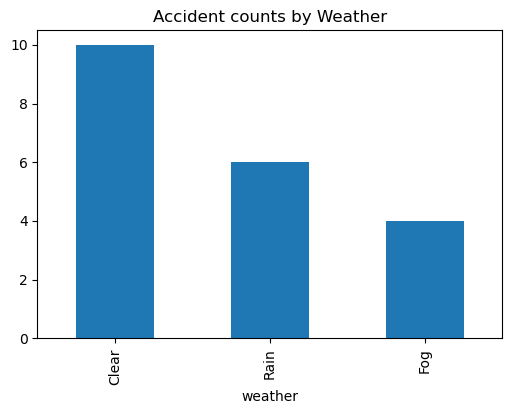


Accidents by Road Condition:
 road_condition
Dry    10
Wet    10
Name: count, dtype: int64 



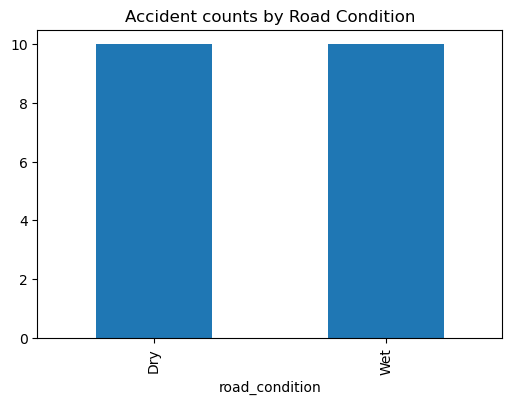


Accidents by Time of Day:
 time_period
Afternoon (12-16)    9
Morning (5-11)       8
Evening (17-20)      3
Name: count, dtype: int64 



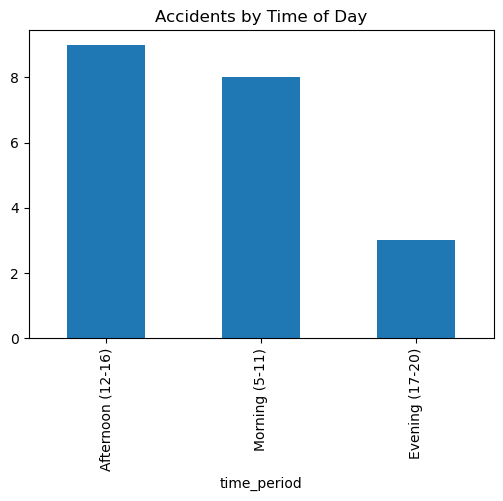


Hourly accident counts:
 hour
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    1
17    1
18    1
19    1
dtype: int64 



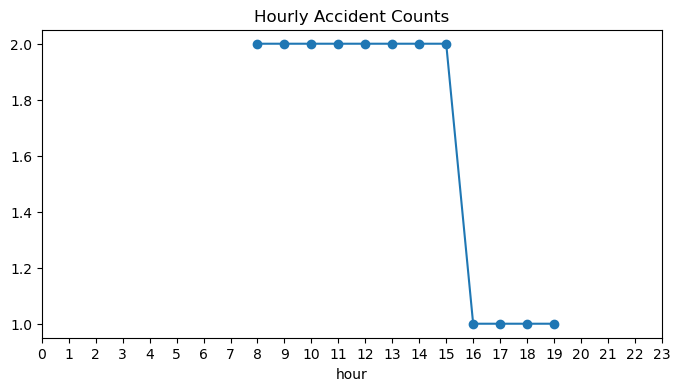

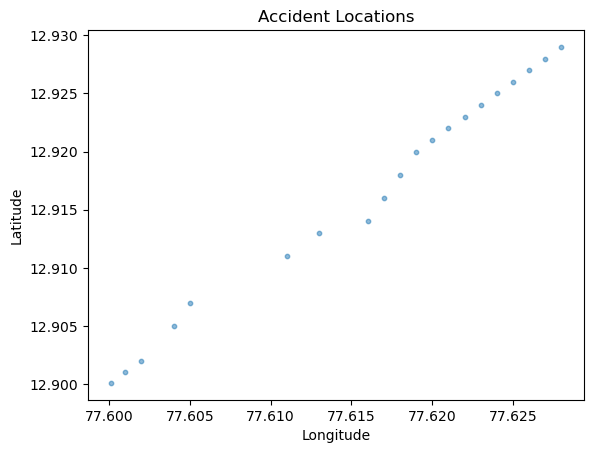

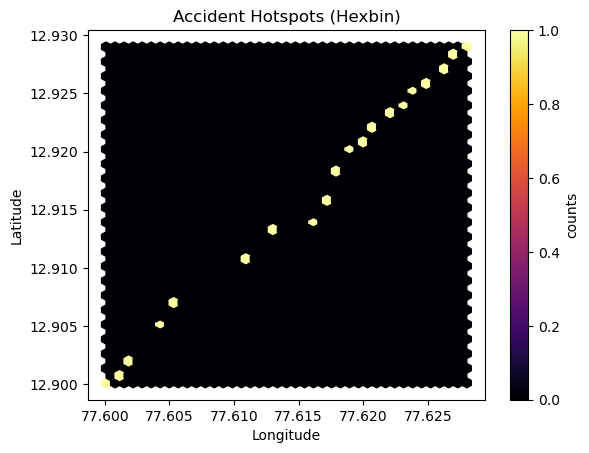


Cluster counts:
 cluster
-1    20
Name: count, dtype: int64 



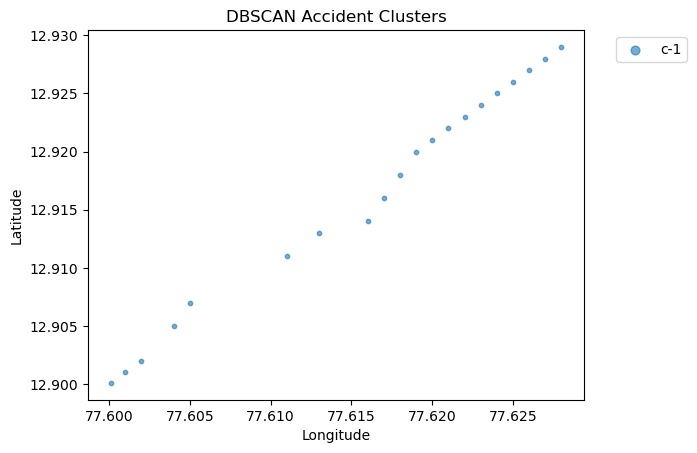

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

INPUT_FILE = "C:/Users/HP/OneDrive/Desktop/accidents.xlsx"  

def load_data(file_path):
    """Load Excel and fix if it's CSV-in-Excel format."""
    df_raw = pd.read_excel(file_path, header=None)
    if df_raw.shape[1] == 1:  # looks like CSV inside Excel
        split_df = df_raw[0].astype(str).str.split(",", expand=True)
        header = split_df.iloc[0].tolist()
        header = [h.strip().lower().replace(" ", "_") for h in header]
        data = split_df.iloc[1:].copy()
        data.columns = header
        df = data.reset_index(drop=True)
    else:
        df = df_raw.copy()
    return df

def preprocess(df):
    """Parse datetime, lat/lon, weather, road condition, time period."""
    # datetime
    dt_col = [c for c in df.columns if "date" in c or "time" in c or c=="datetime"][0]
    df["datetime_parsed"] = pd.to_datetime(df[dt_col], errors="coerce")

    # lat/lon
    lat_col = [c for c in df.columns if "lat" in c][0]
    lon_col = [c for c in df.columns if "lon" in c or "long" in c][0]
    df["latitude"] = pd.to_numeric(df[lat_col], errors="coerce")
    df["longitude"] = pd.to_numeric(df[lon_col], errors="coerce")

    # weather & road
    weather_col = [c for c in df.columns if "weather" in c][0]
    road_col = [c for c in df.columns if "road" in c and "condition" in c][0]
    df["weather"] = df[weather_col].astype(str).str.strip().replace({"nan": None})
    df["road_condition"] = df[road_col].astype(str).str.strip().replace({"nan": None})

    # time period
    df["hour"] = df["datetime_parsed"].dt.hour
    def time_period(h):
        if pd.isna(h): return None
        h = int(h)
        if 5 <= h < 12: return "Morning (5-11)"
        if 12 <= h < 17: return "Afternoon (12-16)"
        if 17 <= h < 21: return "Evening (17-20)"
        return "Night (21-4)"
    df["time_period"] = df["hour"].apply(time_period)

    return df

def analyze_and_plot(df):
    """Show analysis and plots directly."""
    # Weather
    weather_counts = df["weather"].fillna("Unknown").value_counts()
    print("\nAccidents by Weather:\n", weather_counts, "\n")
    weather_counts.plot(kind="bar", figsize=(6,4), title="Accident counts by Weather")
    plt.show()

    # Road
    road_counts = df["road_condition"].fillna("Unknown").value_counts()
    print("\nAccidents by Road Condition:\n", road_counts, "\n")
    road_counts.plot(kind="bar", figsize=(6,4), title="Accident counts by Road Condition")
    plt.show()

    # Time period
    period_counts = df["time_period"].fillna("Unknown").value_counts()
    print("\nAccidents by Time of Day:\n", period_counts, "\n")
    period_counts.plot(kind="bar", figsize=(6,4), title="Accidents by Time of Day")
    plt.show()

    # Hourly trend
    hourly_counts = df.groupby("hour").size()
    print("\nHourly accident counts:\n", hourly_counts, "\n")
    hourly_counts.plot(marker="o", figsize=(8,4), title="Hourly Accident Counts")
    plt.xticks(range(0,24))
    plt.show()

    # Scatter map
    sub = df.dropna(subset=["latitude","longitude"])
    if not sub.empty:
        plt.scatter(sub["longitude"], sub["latitude"], s=10, alpha=0.5)
        plt.title("Accident Locations")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
        plt.show()

        # Hexbin heatmap
        plt.hexbin(sub["longitude"], sub["latitude"], gridsize=40, cmap="inferno")
        plt.colorbar(label="counts")
        plt.title("Accident Hotspots (Hexbin)")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
        plt.show()

        # DBSCAN clustering
        coords = sub[["latitude","longitude"]].values
        scaler = StandardScaler()
        coords_scaled = scaler.fit_transform(coords)
        db = DBSCAN(eps=0.05, min_samples=5).fit(coords_scaled)
        sub["cluster"] = db.labels_

        print("\nCluster counts:\n", sub["cluster"].value_counts(), "\n")

        for cl in sub["cluster"].unique():
            mask = sub["cluster"]==cl
            plt.scatter(sub.loc[mask,"longitude"], sub.loc[mask,"latitude"], s=10, alpha=0.6, label=f"c{cl}")
        plt.title("DBSCAN Accident Clusters")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
        plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
        plt.show()


df_raw = load_data(INPUT_FILE)
df = preprocess(df_raw)
analyze_and_plot(df)
